# RAP tutorial: starting WES QC and data analysis

Using Swiss-Army-Knife

# General steps for quality control of genotype data

1. Genotype array file preparation
2. Liftover genotype array file from GRHc37 to GRCh38
3. Filter variants and samples using pre-specified parameters and subpopulations
4. Whole-exome sequencing QC
5. GWAS using Regenie for the different traits of interest

## GT array file preparation

**How to Run:**
Run this script using: `sh GTprep-merge-files-dxfuse.sh` on the command line

**Inputs**
 - /gwas_cohort_textfiles/phenotypes.txt - not strictly needed, but swiss-army-knife needs at least one input

**Outputs**
- ukb22418_all_v2_merged.bed  
- ukb22418_all_v2_merged.bim 
- ukb22418_all_v2_merged.fam 

**Steps:**
1. copy plink files to instance 1-22+X
2. create a merge list file
3. merge via plink2
4. delete temporary files

**Variables**

- set this to the exome path and data field for your release

exome_file_dir="/Bulk/Exome sequences/Population level exome OQFE variants, PLINK format - final release/"
data_field="ukb23158"

- working dir and reference text file dir
data_file_dir="/data/gt_genrel_block/"
txt_file_dir="/gwas_cohort_textfiles/"

#cmd to run (use as input with `-icmd="{$run_merge}"`)

```
run_merge="cp /mnt/project/Bulk/Genotype\ Results/Genotype\ calls/ukb22418_c[1-9]* . ;\
        cp /mnt/project/Bulk/Genotype\ Results/Genotype\ calls/ukb22418_cX_* . ;\
        ls *.bed | sed -e 's/.bed//g'> files_to_merge.txt; \
        plink --merge-list files_to_merge.txt --make-bed\
        --out ukb22418_all_v2_merged;\
        rm files_to_merge.txt;\
        rm ukb22418_c*"

dx run swiss-army-knife -iin="${txt_file_dir}/phenotypes.txt" \
   -icmd="${run_merge}" --tag="Step1" --instance-type "mem1_ssd1_v2_x16"\
   --destination="${project}:/data/gt_genrel_block/" --brief --yes 
   
```

## Liftover of the genotype array data from GRCh37 to GRCh38

### Generate vcf file

This is necesary if you plan to use Regenie for downstream analysis with the WES and WGS data

This script converts merged plink cohort file generated in step 1 into vcf format using plink in preperation for liftover from b37 to b38. 

**Requirements:**
1. Must have executed 01-GTprep-merge-files-dxfuse.sh

**How to Run:**
Run this shell script using: `sh GTprep-liftover38-vcf.sh` on the command line on your machine

**Inputs:**

- /data/gt_genrel_block/ukb22418_all_v2_mrg.bed 
- /data/gt_genrel_block/ukb22418_all_v2_mrg.bim
- /data/gt_genrel_block/ukb22418_all_v2_mrg.fam

**Output:**

- /data/gt_genrel_block/ukb_gt_p_temp.vcf.gz
  

**Steps:**

1. convert the b37 plink file bed to pgen 
2. convert the b37 pgen file to vcf 
3. delete temp files


**Variables**
```
exome_file_dir="/Bulk/Exome sequences/Population level exome OQFE variants, PLINK format - final release/"
#set this to the exome data field for your release
data_field="ukb22418"
data_file_dir="/data/gt_genrel_block"
txt_file_dir="/gwas_cohort_textfiles"
```

```
run_plink_qc="plink2 --bfile ${data_field}_all_v2_mrg --make-bpgen --out TEMP1 --merge-x --sort-vars n;\
plink2 --bpfile TEMP1 --export vcf bgz --out ukb_gt_p_temp ;\
rm TEMP1.* "


dx run swiss-army-knife -iin="${data_file_dir}/${data_field}_all_v2_mrg.bed" \
   -iin="${data_file_dir}/${data_field}_all_v2_mrg.bim" \
   -iin="${data_file_dir}/${data_field}_all_v2_mrg.fam"\
   -icmd="${run_plink_qc}" --tag="Step1" --instance-type "mem1_ssd1_v2_x16"\
   --destination="${project}:/data/gt_genrel_block/" --brief --yes
```

### Do the liftover

This script liftsover the vcf file generated in GTprep-liftover38-vcf.sh using picard and bcftools. 

**Requirements:**
1. Must have executed GTprep-merge-files-dxfuse.sh
2. Must have executed GTprep-liftover38-vcf.sh

**How to Run:**
Run this shell script using:  `sh GTprep-liftover38.sh` on the command line on your machine

**Inputs:**
- /data/gt_genrel_block/ukb_gt_p_temp.vcf.gz 

**Output:**
- /data/gt_genrel_block/ukb_gt_lo38_sort.vcf.gz

**Steps:**
1. download picard 
2. download liftover chain 
3. copy wes grch38 fasta and dictionary from RAP
4. run liftover using picard
5. sort and gzip vcf file


**Variables**
```
exome_file_dir="/Bulk/Exome sequences/Population level exome OQFE variants, PLINK format - final release/"
#set this to the exome data field for your release
data_field="ukb22418"
data_file_dir="/data/gt_genrel_block"
txt_file_dir="/gwas_cohort_textfiles"
```

```
run_plink_qc="wget https://github.com/broadinstitute/picard/releases/download/2.27.4/picard.jar ;\
wget https://raw.githubusercontent.com/broadinstitute/gatk/master/scripts/funcotator/data_sources/gnomAD/b37ToHg38.over.chain ;\
cp /mnt/project/Bulk/Exome\ sequences/Exome\ OQFE\ CRAM\ files/helper_files/GRCh38_full_analysis_set_plus_decoy_hla.* . ;\
java -jar picard.jar LiftoverVcf -I ukb_gt_p_temp.vcf.gz -O ukb_gt_lo38.vcf \
   -C b37ToHg38.over.chain --REJECT rejected_variants.vcf -R GRCh38_full_analysis_set_plus_decoy_hla.fa \
   --RECOVER_SWAPPED_REF_ALT true --DISABLE_SORT true ;\
bcftools sort -o ukb_gt_lo38_sort.vcf.gz -O z ukb_gt_lo38.vcf  "



dx run swiss-army-knife -iin="${data_file_dir}/ukb_gt_p_temp.vcf.gz" \
   -icmd="${run_plink_qc}" --tag="Step1" --instance-type "mem2_ssd1_v2_x16"\
   --destination="${project}:/data/gt_genrel_block/" --brief --yes
```

### Convert vcf to plink

This script to convert liftover vcf file generated in GTprep-liftover38.sh back to plink format. 

**Requirements:**
1. Must have executed GTprep-merge-files-dxfuse.sh
2. Must have executed GTprep-liftover38-vcf.sh
3. Must have executed GTprep-liftover38.sh

**How to Run:**

Run this shell script using: `sh GTprep-lo38toplink.sh` on the command line on your machine

**Inputs:**
    
- /data/gt_genrel_block/ukb_gt_lo38_sort.vcf.gz
- /data/gt_genrel_block/ukb22418_all_v2_mrg.fam 
- /gwas_cohort_textfiles/phenotypes.txt

**Output:**
    
- /data/gt_genrel_block/ukb22418_allQC_mrg_lo38_v3.bed
- /data/gt_genrel_block/ukb22418_allQC_mrg_lo38_v3.bim
- /data/gt_genrel_block/ukb22418_allQC_mrg_lo38_v3.fam


**Steps:**
    
1. convert lo38 vcf file to plink
2. add fam info to plink
4. remove temp plink files
5. extract rsids for snps on alt contigs
6. remove snps from alt contigs and save plink format


**Variables**

```
exome_file_dir="/Bulk/Exome sequences/Population level exome OQFE variants, PLINK format - final release/"
#set this to the exome data field for your release
data_field="ukb22418"
data_file_dir="/data/gt_genrel_block"
txt_file_dir="/gwas_cohort_textfiles"
```

```
run_plink_qc="plink2 --vcf ukb_gt_lo38_sort.vcf.gz --make-bed --out ukb_gt_lo38_temp --id-delim "_" \
  --indiv-sort f ${data_field}_allQC_v2_mrg.fam --ref-allele force ukb_gt_lo38_sort.vcf.gz 4 3 '#' \
  --alt1-allele force ukb_gt_lo38_sort.vcf.gz 5 3 '#' --allow-extra-chr ;\
plink2 --bfile ukb_gt_lo38_temp --make-bed --out ${data_field}_allQC_mrg_lo38_v2 \
  --fam ${data_field}_allQC_v2_mrg.fam --allow-extra-chr ;\
rm ukb_gt_lo38_temp.* ;\
grep alt ukb22418_allQC_mrg_lo38_v2.bim | awk '{print $2}' > remove_losnps.txt; \
plink2 --bfile ${data_field}_allQC_mrg_prnd_cohort_lo38_v2 --exclude remove_losnps.txt --make-bed \
  -out ${data_field}_allQC_mrg_lo38_v3 --allow-extra-chr "


dx run swiss-army-knife -iin="${data_file_dir}/ukb_gt_lo38_sort.vcf.gz" \
   -iin="${data_file_dir}/${data_field}_allQC_v2_mrg_prun_cohort.fam"\
   -iin="${txt_file_dir}/phenotypes.v08-04-22.txt" \
   -icmd="${run_plink_qc}" --tag="Step1" --instance-type "mem2_ssd1_v2_x16"\
   --destination="${project}:/data/gt_genrel_block/" --brief --yes
```

## Filter samples and variants using pre-specified parameters and subpopulations

This script runs the QC process using PLINK on the merged file generated in step 01 or in the liftover files

FIXME: decide what's best 1. Merge, filter and liftover or 2. Merge, liftover and filter 

**Requirements:**

1. Must have executed GTprep-merge-files-dxfuse.sh
2. Must have executed GTprep-liftover38-vcf.sh
3. Must have executed GTprep-liftover38.sh
4. Must have executed GTprep-lo38toplink.sh

**How to Run:** Run this shell script using: `sh 02-step1-qc-filter.sh` on the command line on your machine

**Inputs:**

- /data/gt_genrel_block/ukb22418_all_v2_merged.bed
- /data/gt_genrel_block/ukb22418_all_v2_merged.bim
- /data/gt_genrel_block/ukb22418_all_v2_merged.fam

**Outputs:**

- /data/gt_genrel_block/ukb22418_allQC_v2_merged.bed 
- /data/gt_genrel_block/ukb22418_allQC_v2_merged.bim
- /data/gt_genrel_block/ukb22418_allQC_v2_merged.fam

**Steps:**

1. filter merged file for QC metrics


**Variables**
```
exome_file_dir="/Bulk/Exome sequences/Population level exome OQFE variants, PLINK format - final release/"
#set this to the exome data field for your release
data_field="ukb22418"
# working dir and reference text file dir
data_file_dir="/data/gt_genrel_block"
txt_file_dir="/gwas_cohort_textfiles"
```

```
run_plink_qc="plink2 --bfile ${data_field}_all_v2_merged\
 --maf 0.01 --mac 20 --geno 0.1 \
 --mind 0.1 --make-bed\
 --out  ${data_field}_allQC_v2_merged"

dx run swiss-army-knife -iin="${data_file_dir}/${data_field}_all_v2_merged.bed"\
   -iin="${data_file_dir}/${data_field}_all_v2_merged.bim" \
   -iin="${data_file_dir}/${data_field}_all_v2_merged.fam"\
   -icmd="${run_plink_qc}" --tag="Step1" --instance-type "mem1_ssd1_v2_x16"\
   --destination="${project}:/data/gt_genrel_block/" --brief --yes
```

### Do LD pruning 

This script runs the prunes the merged plink file generated in 02-step1-qc-filter.sh using plink. 

**Requirements:**

1. Must have executed 01-GTprep-merge-files-dxfuse.sh
2. Must have executed 02-step1-qc-filter.sh

**How to Run:** Run this shell script using: `sh 02-step1-qc-filter.sh` on the command line on your machine

**Inputs:**
- /data/gt_genrel_block/ukb22418_allQC_v2_merged.bed
- /data/gt_genrel_block/ukb22418_allQC_v2_merged.bim
- /data/gt_genrel_block/ukb22418_allQC_v2_merged.fam
- /gwas_cohort_textfiles/phenotypes.txt

**Outputs:**
- /data/gt_genrel_block/ukb22418_allQC_v2_mrg_prun_cohort.bed 
- /data/gt_genrel_block/ukb22418_allQC_v2_mrg_prun_cohort.bim
- /data/gt_genrel_block/ukb22418_allQC_v2_mrg_prun_cohort.fam

**Steps:**
1. identify snps of high LD
2. remove pruned snps and save pruned, QCed, plink file 


**Variables**
exome_file_dir="/Bulk/Exome sequences/Population level exome OQFE variants, PLINK format - final release/"
#set this to the exome data field for your release
data_field="ukb22418"
data_file_dir="/data/gt_genrel_block"
txt_file_dir="/gwas_cohort_textfiles"

```
run_plink_qc="plink2 --bfile ${data_field}_allQC_v2_merged \
 --indep-pairwise 1000 50 0.4  --out ukb-pruning ;\
ls *bed; \
plink2 --bfile ${data_field}_allQC_v2_merged --extract ukb-pruning.prune.in \
 --keep phenotypes.v08-04-22.txt --make-bed --out ${data_field}_allQC_v2_mrg_prun_cohort ;\
wc *.bim "

dx run swiss-army-knife -iin="${data_file_dir}/${data_field}_allQC_v2_merged.bed" \
   -iin="${data_file_dir}/${data_field}_allQC_v2_merged.bim" \
   -iin="${data_file_dir}/${data_field}_allQC_v2_merged.fam"\
   -iin="${txt_file_dir}/phenotypes.v08-04-22.txt" \
   -icmd="${run_plink_qc}" --tag="Step1" --instance-type "mem1_ssd1_v2_x16"\
   --destination="${project}:/data/gt_genrel_block/" --brief --yes
```

### Discussion topics

1. Order of operations. 
    - Merge GT array files, filter and prune then do liftover 
        - Advantages: 
        1. Create the minimal datafile to be used to generate the GRM or block regressions of REGENIE
        2. Rule of the thumb for regenie step 1: a) genome-wide file, b) have roughly the same number of markers than subjects
        3. Prunning markers in high LD maintains relationship and population structure in the data, creates a smaller file and accelerates liftover step (which is done  in ~400K variants)
    - Merge GT array files, do liftover, filter and prune
        - Advantages:
        1. Keeps all the variants from the GT array file in case we want to analyze this file specifically 
        2. We can still do the filter and prunning in this hg38 file to match the process in the hg19 
                
2. Parameters:
    - For plink filtering: 
        - maf=0.01
        - mac=20 ?
        - geno=0.1
        - mind=0.1
        - HWE ? With the sample size in the UKB even minor deviations from the HWE will result in highly significant p-values which removes variants from the analysis. Some people have recommended to use very low p-values as threshold (1e-30 or 1e-60) 
        
     - For plink prunning: depending if used for PCA analysis or not how strict should the prunning be (~150K variants vs ~400k variants)
         - window=50 or 1000
         - shift=10  or 50
         - r2=0.1 or 0.4


## Perform GWAS on WES data using REGENIE

This script runs the step1 analysis for regenie.

**Requirements:**

1. Must have executed all scripts including liftover from 01_prep_gtfile_4_GWAS

**How to Run:** Run this shell script using: `sh 09b-GT-regenie38.sh` on the command line on your machine

**Inputs:**
- /data/gt_genrel_block/ukb22418_allQC_mrg_prnd_cohort_lo38_v3.bed
- /data/gt_genrel_block/ukb22418_allQC_mrg_prnd_cohort_lo38_v3.bim
- /data/gt_genrel_block/ukb22418_allQC_mrg_prnd_cohort_lo38_v3.fam
- /gwas_cohort_textfiles/phenotypes.v08-04-22.txt
- /gwas_cohort_textfiles/covariates.v08-04-22.txt

**Output:**
- /data/ap_wes_gwas/ap38_results_1.loco.gz - Leave One Chromosome Out results (used in part F)
- /data/ap_wes_gwas/ap38_results_pred.list - List of files generated this step (used in part F)
- /data/ap_wes_gwas/ap38_results.log

**Steps:**
1. run regenie


**Variables**
```
exome_file_dir="/Bulk/Exome sequences/Population level exome OQFE variants, PLINK format - final release/"
#set this to the exome data field for your release
data_field="ukb22418"
data_file_dir="/data/gt_genrel_block"
txt_file_dir="/gwas_cohort_textfiles"
```

```
run_regenie_cmd="regenie --step 1 --out ap38_results \
 --bed ukb22418_allQC_mrg_prnd_cohort_lo38_v3 \
 --phenoFile phenotypes.v08-04-22.txt \
 --covarFile covariates.v08-04-22.txt \
 --phenoCol AP --covarCol age \
 --covarCol sex.b2 --covarCol bmi \
 --covarCol smoke --covarCol pca{1:9} \
 --bsize 1000 --bt --loocv --gz --threads 16 "


dx run swiss-army-knife -iin="${data_file_dir}/${data_field}_allQC_mrg_prnd_cohort_lo38_v3.bed" \
   -iin="${data_file_dir}/${data_field}_allQC_mrg_prnd_cohort_lo38_v3.bim" \
   -iin="${data_file_dir}/${data_field}_allQC_mrg_prnd_cohort_lo38_v3.fam"\
   -iin="${txt_file_dir}/phenotypes.v08-04-22.txt" \
   -iin="${txt_file_dir}/covariates.v08-04-22.txt" \
   -icmd="${run_regenie_cmd}" --tag="Step1" --instance-type "mem1_ssd1_v2_x16" \
   --destination="${project}:/data/ap_wes_gwas/" --brief --yes;
```

### USE WES data QC from the plink final released files

This script runs the cohort and QC filter on te WES data using plink

**Requirements:**
 5. Must have executed: 
    - all scripts including liftover from 01_prep_gtfile_4_GWAS


**How to Run:** Run this shell script using: `sh 11b-gwas-s2-wes38-qc-filter` on the command line on your own machine

**Inputs:**

Note that you can adjust the output directory by setting the data_file_dir variable
- /gwas_cohort_textfiles/phenotypes.v08-04-22.tx - from part A (please refer to notebook & slides)

for each chromosome, you will run a separate worker
- /{exome_file_dir}/ukb23158_c1_b0_v1.bed 
- /{exome_file_dir}/ukb23158_c1_b0_v1.bim 
- /{exome_file_dir}/ukb23158_c1_b0_v1.bam 

**Outputs (for each chromosome):**
- /data/ap_wes_gwas/WES_c1_snps_qc_pass.id  
- /data/ap_wes_gwas/WES_c1_snps_qc_pass.snplist - used in Part F 
- /data/ap_wes_gwas/WES_c1_snps_qc_pass.log

**Steps:**
1. for each chromosome 1-22 and X:
- filter by QC metrics and cohort
- write out list of snps and ids that pass filter

```
#set this to the exome sequence directory that you want (should contain PLINK formatted files)
exome_file_dir="/Bulk/Exome sequences/Population level exome OQFE variants, PLINK format - final release/"
#set this to the exome data field for your release
data_field="ukb23158"
data_file_dir="/data/ap_wes_gwas/"
txt_file_dir="/gwas_cohort_textfiles/"

```

```
for i in {1..22}; do
    run_plink_wes="plink2 --bfile ${data_field}_c${i}_b0_v1\
      --no-pheno --keep phenotypes.v08-04-22.txt \
      --maf 0.0005 --mac 20 --geno 0.1 --mind 0.1\
      --write-snplist --write-samples --no-id-header\
      --out WES_c${i}_snps_qc_pass"

    dx run swiss-army-knife -iin="${exome_file_dir}/${data_field}_c${i}_b0_v1.bed" \
     -iin="${exome_file_dir}/${data_field}_c${i}_b0_v1.bim" \
     -iin="${exome_file_dir}/${data_field}_c${i}_b0_v1.fam"\
     -iin="${txt_file_dir}/phenotypes.v08-04-22.txt" \
     -icmd="${run_plink_wes}" --tag="Step2" --instance-type "mem1_ssd1_v2_x16"\
     --destination="${project}:/data/ap_wes_gwas/" --brief --yes
done


    run_plink_wes="plink2 --bfile ${data_field}_cX_b0_v1\
      --no-pheno --keep phenotypes.v08-04-22.txt \
      --maf 0.0005 --mac 20 --geno 0.1  --mind 0.1\
      --write-snplist --write-samples --no-id-header\
      --out WES_cX_snps_qc_pass"
    
    dx run swiss-army-knife -iin="${exome_file_dir}/${data_field}_cX_b0_v1.bed" \
     -iin="${exome_file_dir}/${data_field}_cX_b0_v1.bim" \
     -iin="${exome_file_dir}/${data_field}_cX_b0_v1.fam"\
     -iin="${txt_file_dir}/phenotypes.v08-04-22.txt" \
     -icmd="${run_plink_wes}" --tag="Step2" --instance-type "mem1_ssd1_v2_x16"\
     --destination="${project}:/data/ap_wes_gwas/" --brief --yes
```

### Run step 2 of regenie with the WES Qc'ed data

This script runs the step2 analysis for regenie on WES data.

**Requirements: **
0-4 - please refer to readme.md
5. Must have executed: 
- all scripts including liftover from 01_prep_gtfile_4_GWAS
- 09b-step1-regenie.sh
- 11b-gwas-s2-wes38-qc-filter.sh

**How to Run:** Run this shell script using: `sh 12b-gwas-s2-wes38-regenie.sh` on the command line on your own machine

**Inputs:**
Note that you can adjust the output directory by setting the data_file_dir variable
- /gwas_cohort_textfiles/phenotypes.v08-04-22.txt - from part A (please refer to notebook & slides)
- /gwas_cohort_textfiles/covariates.v08-04-22.txt - from part A (please refer to notebook & slides)
- /data/ap38_results_1.loco.gz - from 09b-step1-regenie.sh
- /data/ap38_results_pred.list - from 09b-step1-regenie.sh

**Additional inputs**
for each chromosome, you will run a separate worker
- /{exome_file_dir}/ukb23158_c1_b0_v1.bed - Chr1 file for 200k release
- /{exome_file_dir}/ukb23158_c1_b0_v1.bim 
- /{exome_file_dir}/ukb23158_c1_b0_v1.bam 
- /data/ap_wes_gwas/WES_c1_snps_qc_pass.snplist - from 11b-gwas-s2-wes38-qc-filter.sh

**Outputs (for each chromosome):**
- /data/ap_wes_gwas/assoc.c1_AP.regenie.gz - regenie results for chromosome 1 
note that if you have multiple phenotypes, you will have a .regenie.gz for each phenotype
- /data/ap_wes_gwas/assoc.c1.log  - regenie log for chromosome 1

**Steps:**
1. for each chromosome 1-22 and X:
    - run regenie 

```
exome_file_dir="/Bulk/Exome sequences/Population level exome OQFE variants, PLINK format - final release/"
#set this to the exome data field for your release
data_field="ukb23158"
data_file_dir="/data/ap_wes_gwas/"
txt_file_dir="/gwas_cohort_textfiles/"
```
```
for chr in {1..22}; do
  run_regenie_cmd="regenie --step 2 --out assoc.c${chr} \
    --bed ${data_field}_c${chr}_b0_v1 \
    --phenoFile phenotypes.v08-04-22.txt --covarFile covariates.v08-04-22.txt \
    --bt --approx --firth-se --firth --extract WES_c${chr}_snps_qc_pass.snplist \
    --phenoCol AP --covarCol age --covarCol sex.b2 --covarCol bmi --covarCol smoke \
    --covarCol pca{1:9} --pred ap38_results_pred.list --bsize 200 \
    --pThresh 0.05 --minMAC 3 --threads 16 --gz"

  dx run swiss-army-knife -iin="${exome_file_dir}/${data_field}_c${chr}_b0_v1.bed" \
   -iin="${exome_file_dir}/${data_field}_c${chr}_b0_v1.bim" \
   -iin="${exome_file_dir}/${data_field}_c${chr}_b0_v1.fam" \
   -iin="${data_file_dir}/WES_c${chr}_snps_qc_pass.snplist" \
   -iin="${txt_file_dir}/phenotypes.v08-04-22.txt" \
   -iin="${txt_file_dir}/covariates.v08-04-22.txt" \
   -iin="${data_file_dir}/ap38_results_pred.list" \
   -iin="${data_file_dir}/ap38_results_1.loco.gz" \
   -icmd="${run_regenie_cmd}" --tag="Step2" --instance-type "mem1_ssd1_v2_x16"\
   --destination="${project}:/data/ap_wes_gwas/" --brief --yes

done


  run_regenie_cmd="regenie --step 2 --out assoc.cX \
    --bed ${data_field}_cX_b0_v1 \
    --phenoFile phenotypes.v08-04-22.txt --covarFile covariates.v08-04-22.txt \
    --bt --approx --firth-se --firth --extract WES_cX_snps_qc_pass.snplist \
    --phenoCol AP --covarCol age --covarCol sex.b2 --covarCol bmi --covarCol smoke \
    --covarCol pca{1:9} --pred ap38_results_pred.list --bsize 200 \
    --pThresh 0.05 --minMAC 3 --threads 16 --gz"

  dx run swiss-army-knife -iin="${exome_file_dir}/${data_field}_cX_b0_v1.bed" \
   -iin="${exome_file_dir}/${data_field}_cX_b0_v1.bim" \
   -iin="${exome_file_dir}/${data_field}_cX_b0_v1.fam" \
   -iin="${data_file_dir}/WES_cX_snps_qc_pass.snplist" \
   -iin="${txt_file_dir}/phenotypes.v08-04-22.txt" \
   -iin="${txt_file_dir}/covariates.v08-04-22.txt" \
   -iin="${data_file_dir}/ap38_results_pred.list" \
   -iin="${data_file_dir}/ap38_results_1.loco.gz" \
   -icmd="${run_regenie_cmd}" --tag="Step2" --instance-type "mem1_ssd1_v2_x16"\
   --destination="${project}:/data/ap_wes_gwas/" --brief --yes
```

# Quality control on the WES final release 450K exomes

More information [here](https://dnanexus.gitbook.io/uk-biobank-rap/science-corner/whole-exome-sequencing-oqfe-protocol/generation-and-utilization-of-quality-control-set-90pct10dp-on-oqfe-data/details-on-processing-the-300k-exome-data-to-generate-the-quality-control-set)

WES final release comprises:
    
- single and multi-sample variant data generated with the OQFE mapping protocol
- variants are called with DeepVariants and 
- aggregated into a multi-sample VCF with GLnexus

UKB provided an auxiliary file  `ukb23145_300k_OQFE.90pct10dp_qc_variants.txt` that contains those variants failing the filter

The purpose of this file is to provide a very basic QC to mitigate spurious associations in GWAS analyses produce by coverage heterogeneities. 

In this variant level filter it is required at least 90% of the genotypes for a given variant and a read depth of at least 10 (DP>=10)

```
bcftools norm -m - -f <reference> -Oz -o <normVCF> <inputVCF>
bcftools view -i 'F_PASS(DP>=10 & GT!="mis")> 0.9' -Oz -o <filtered_normVCF> <normVCF>
```


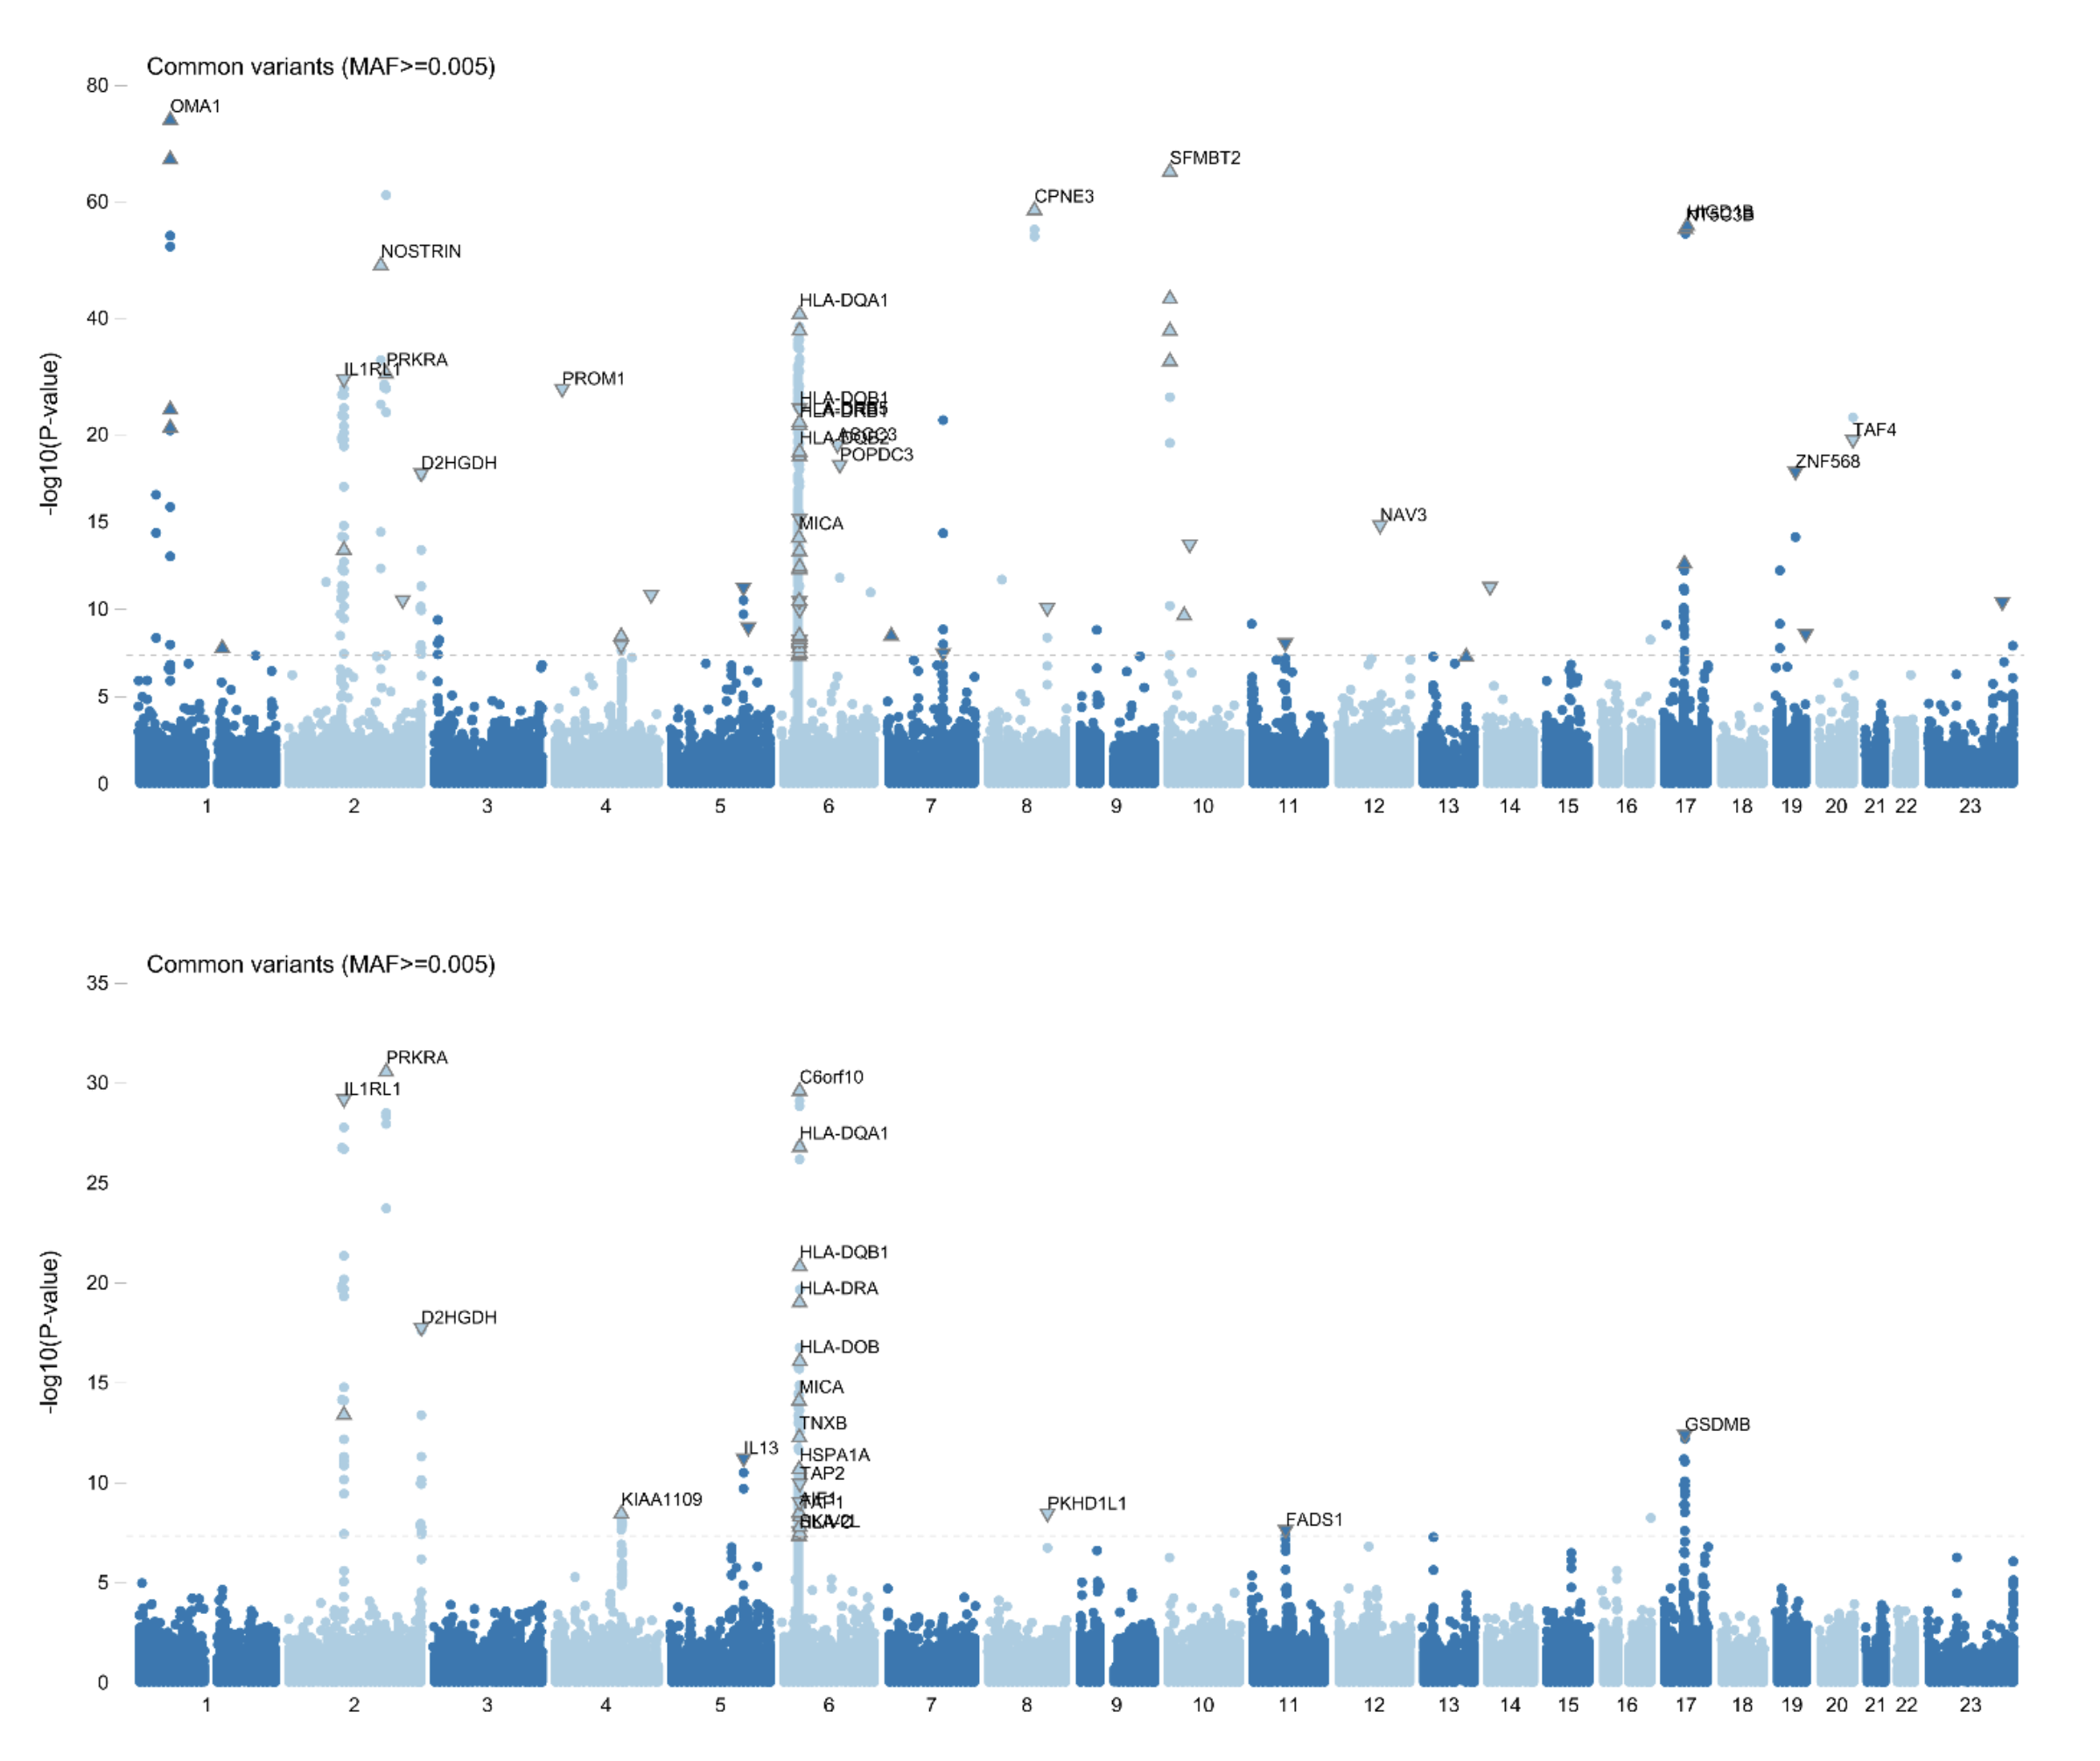

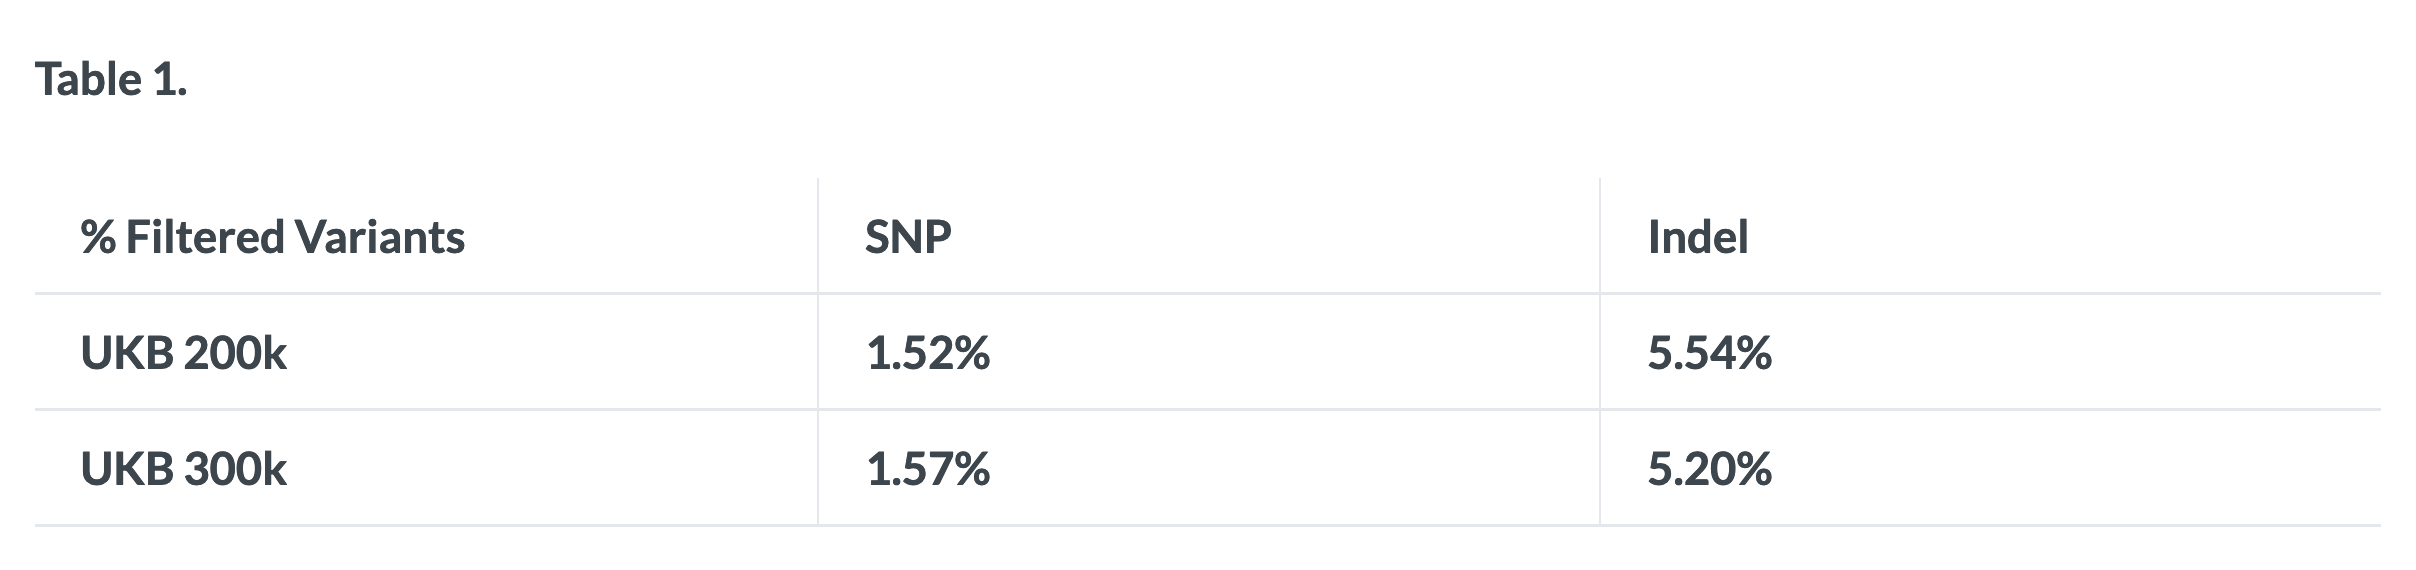

In [ ]:
module load Singularity/3.5.3
sos dryrun /home/dmc2245/project/UKBB_GWAS_dev/workflow/VCF_QC_pipeline.ipynb \
    qc\
    --cwd /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/plink_files     \
--vcfs /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/ukb23156_c*     \
--ref_hg38 /home/dmc2245/software/GRCh38_reference_genome/GRCh38_full_analysis_set_plus_decoy_hla.fa     \
--DP_snp 10     \
--DP_indel 10     \
--GQ 20     \
--AB_snp 0.15     \
--AB_indel 0.2     \
--container_lmm /mnt/mfs/statgen/containers/lmm.sif

# Investigate number of WES samples in RAP using jupyter notebook

In [ ]:
# Import packages
import dxpy
import dxdata

In [ ]:
# Automatically discover dispensed dataset ID and load the dataset
#dispensed_dataset_id = dxpy.find_one_data_object(typename='Dataset', name='app*.dataset', folder='/', name_mode='glob')['id']
#dataset = dxdata.load_dataset(id=dispensed_dataset_id)

In [ ]:
import pandas as pd

# Get WES
path_to_WES = '/mnt/project/Bulk/Exome sequences/Population level exome OQFE variants, PLINK format - final release/ukb23158_c22_b0_v1.fam' #replace this with actual path to the WES file
plink_fam_WES = pd.read_csv(path_to_WES, delimiter='\s', dtype='object',
                           names = ['FID','IID','Father ID','Mother ID', 'sex', 'Pheno'], engine='python')

# Get GT array
path_to_GT = '/mnt/project/Bulk/Genotype Results/Genotype calls/ukb22418_c22_b0_v2.fam'
plink_fam_GT = pd.read_csv(path_to_GT, delimiter='\s', dtype='object',
                           names = ['FID','IID','Father ID','Mother ID', 'sex', 'Pheno'], engine='python')

wes_GT_ind=plink_fam_WES[plink_fam_WES.FID.isin(plink_fam_GT.FID)]

# Write phenotype files to a TSV file
wes_GT_ind.to_csv('WES_GT_ind_list.tsv', sep='\t', index=False, quoting=3)


%%bash
# Upload the geno-pheno intersect phenotype file back to the RAP project
dx upload WES_GT_ind_list.tsv -p --path /mnt/project/data --brief
